In [32]:
import trenchripper as tr

import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import sklearn as skl
import scipy as sp
import matplotlib as mpl

import warnings
import copy
import random

import scipy.stats
from sklearn.linear_model import LinearRegression

import goatools
import goatools.base
from goatools.base import download_go_basic_obo
from goatools.obo_parser import GODag
from goatools.anno.gaf_reader import GafReader

from matplotlib import pyplot as plt

random.seed(42)
np.random.seed(42)

dask_wd = "/home/de64/scratch/de64/dask"
warnings.filterwarnings(action='once',category=UserWarning)
plt.style.use('./deaton.mplstyle')

### Load Functions

In [33]:
def get_std(plate_data,plate_map,plate_map_std_dict):
    standard_vals = []
    standard_signal = []
    for key,val in plate_map_std_dict.items():
        selected_data = np.array(plate_data[plate_map==key]).flatten()
        selected_data = selected_data[~np.isnan(selected_data)]
        working_standard_vals = [val for i in range(len(selected_data))]
        standard_vals += working_standard_vals
        standard_signal += list(selected_data)
    standard_vals = np.array(standard_vals)
    standard_signal = np.array(standard_signal)
    return standard_vals,standard_signal

def linear_regression(plate_data,plate_map,plate_map_std_dict):
    ##extract standard values
    std_vals,std_signal = get_std(plate_data,plate_map,plate_map_std_dict)
    
    ##linear regression
    reg = skl.linear_model.LinearRegression().fit(std_vals.reshape(-1,1),std_signal)
    predict = reg.predict(std_vals.reshape(-1,1))
    resid = (std_signal - predict)
    reg_uncertainty = np.sqrt(np.sum(resid**2)/(len(resid)-2))
    slope_uncertainty = reg_uncertainty/np.sqrt(np.sum((std_vals-np.mean(std_vals))**2))

    ## calculating LOQ by standard error of regression slope
    deriv = reg.coef_[0]    
    intercept = reg.intercept_
    loq = 10*(slope_uncertainty/deriv)
    print("LOQ: " + str(loq))
    
    predicted_concentrations = plate_data.apply(lambda x: (x-intercept)/deriv)
    samples_mask = ~plate_map.isin(list(plate_map_std_dict.keys()) + [np.NaN])
    all_samples_list = plate_map.values[samples_mask.values]
    all_sample_vals_list = predicted_concentrations.values[samples_mask.values]
    return all_samples_list,all_sample_vals_list

def get_sample_idx(sample_name_list):
    sample_idx = []
    for sample_name in sample_name_list:
        strain,iptg,run_idx,replicate = sample_name.split("\n")
        iptg = int(iptg)
        run_idx = int(run_idx[1:])
        replicate = int(replicate)
        sample_idx.append((strain,iptg,run_idx,replicate))
    return sample_idx

def search_go(ns2assoc, obodag, inv_gene_to_id, go_term):
    namespace_abbv = {"biological_process":"BP","molecular_function":"MF","cellular_component":"CC"}
    
    print("Searching for " + str(obodag[go_term].name))
    namespace = namespace_abbv[obodag[go_term].namespace]
    child_goterms = list(obodag[go_term].get_all_children())
    gene_list = [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if go_term in val]
    for child_goterm in child_goterms:    
        gene_list += [inv_gene_to_id[key] for key,val in ns2assoc[namespace].items() if child_goterm in val]
    gene_list = sorted(list(set(gene_list)))
    return gene_list

### Load Data

In [34]:
Protein_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_1.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_2.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_plate_3 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_3.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_1 = pd.concat([Protein_data_plate_1,Protein_data_plate_2,Protein_data_plate_3]).reset_index(drop=True)

RNA_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_1.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_2.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_plate_3 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_3.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_1 = pd.concat([RNA_data_plate_1,RNA_data_plate_2,RNA_data_plate_3]).reset_index(drop=True)

In [35]:
Protein_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skipfooter=11,index_col=0,usecols=range(2))['Concentrations (ug/mL)'].to_dict()
RNA_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skipfooter=9,index_col=0,usecols=range(2))['Concentrations (ng/ul)'].to_dict()

Protein_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_3 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/Protein_Plate_Map_3.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_merged_1 = pd.concat([Protein_plate_map_1,Protein_plate_map_2,Protein_plate_map_3]).reset_index(drop=True)
Protein_plate_map_merged_1.columns = Protein_plate_map_merged_1.columns.astype(int)

RNA_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_3 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/R_Protein_Knockdowns/RNA_Protein/RNA_Plate_Map_3.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_merged_1 = pd.concat([RNA_plate_map_1,RNA_plate_map_2,RNA_plate_map_3]).reset_index(drop=True)
RNA_plate_map_merged_1.columns = RNA_plate_map_merged_1.columns.astype(int)

In [36]:
WT_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE26_Imaging/2024-02-10_lDE26_Steady_State_df_Estimators_wStats.pkl")
WT_ss_estimators_df = WT_ss_estimators_df.loc["Mean (Robust)"]
RelA_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE28_Imaging/2024-02-26_lDE28_Steady_State_df_Estimators_wStats.pkl")
RelA_ss_estimators_df = RelA_ss_estimators_df.loc["Mean (Robust)"]
SpoT_ss_estimators_df = pd.read_pickle("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/lDE30_Imaging/2024-02-26_lDE30_Steady_State_df_Estimators_wStats.pkl")
SpoT_ss_estimators_df = SpoT_ss_estimators_df.loc["Mean (Robust)"]

## Figure 6A

In [37]:
protein_samples_list_1,protein_sample_vals_list_1 = linear_regression(Protein_data_1,Protein_plate_map_merged_1,Protein_plate_map_standard_dict)
RNA_samples_list_1,RNA_sample_vals_list_1 = linear_regression(RNA_data_1,RNA_plate_map_merged_1,RNA_plate_map_standard_dict)

protein_samples_idx_1 = get_sample_idx(protein_samples_list_1)
Protein_output_df_1 = pd.DataFrame(protein_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","IPTG (uM)","Run","Replicate"]))

RNA_output_df_1 = (pd.DataFrame(RNA_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","IPTG (uM)","Run","Replicate"]))/2)*20
RNA_prot_ratio_df_1 = (RNA_output_df_1/Protein_output_df_1).sort_index()
RNA_prot_ratio_df_1["Technical Replicate"] = 1

RNA_prot_ratio_df_1 = RNA_prot_ratio_df_1.reset_index().set_index(["Strain","IPTG (uM)","Run","Replicate","Technical Replicate"])

RNA_prot_ratio_df = pd.concat([RNA_prot_ratio_df_1]).sort_index()

LOQ: 0.1554300881865585
LOQ: 0.33187324528946505


In [38]:
RNA_prot_ratio_df_translation = RNA_prot_ratio_df.reset_index()
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation[RNA_prot_ratio_df_translation["IPTG (uM)"].isin([0,25,50])]
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation[RNA_prot_ratio_df_translation["Strain"].isin(['DE759', 'DE760', 'DE761', 'DE763', 'DE764', 'DE773', 'DE774', 'DE777', 'DE785'])]

strain_name_map = {'DE759':'prfB', 'DE760':'rplA', 'DE761':'rplQ', 'DE763':'fusA', 'DE764':'infA', 'DE773':'WT', 'DE774':'rplL',
       'DE777':'pheT', 'DE785':'rpsO'}
strain_order = ["WT","rpsO","rplQ","rplA"]
# strain_order = ["WT","rpsO","rplQ","rplA","infA","prfB","pheT","fusA","rplL"]
# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'rpsO':(0.8901960784313725, 0.4666666666666667, 0.7607843137254902), \
                   'rplQ':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'rplA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'infA':(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), \
                   'prfB':(0.5803921568627451, 0.403921568627451, 0.7411764705882353), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725),\
                   'fusA':(0.17254901960784313, 0.6274509803921569, 0.17254901960784313), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177)}

RNA_prot_ratio_df_translation["Strain"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x])
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.set_index(["Strain","IPTG (uM)","Run","Replicate","Technical Replicate"])
RNA_prot_ratio_df_translation.columns = ['RNA/Protein']
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.loc[strain_order]

RNA_prot_ratio_df_tech_agg = RNA_prot_ratio_df_translation.groupby(["Strain","IPTG (uM)","Run","Replicate"]).mean()

mean_RNA_Prot_df = RNA_prot_ratio_df_tech_agg.groupby(["Strain","IPTG (uM)"]).mean()
mean_RNA_Prot_df.columns = ["Mean"]
mean_RNA_Prot_df["SEM"] = RNA_prot_ratio_df_tech_agg.groupby(["Strain","IPTG (uM)"]).sem()['RNA/Protein']
mean_RNA_Prot_df["P-val (No Induction)"] = RNA_prot_ratio_df_tech_agg.groupby(["Strain","IPTG (uM)"]).apply(lambda x: sp.stats.ttest_ind(x.values.T[0],\
                                                RNA_prot_ratio_df_tech_agg.loc["WT",0].values.T[0]).pvalue)
mean_RNA_Prot_df["P-val (25uM IPTG)"] = RNA_prot_ratio_df_tech_agg.groupby(["Strain","IPTG (uM)"]).apply(lambda x: sp.stats.ttest_ind(x.values.T[0],\
                                                RNA_prot_ratio_df_tech_agg.loc["WT",25].values.T[0]).pvalue)
mean_RNA_Prot_df = mean_RNA_Prot_df.loc[strain_order]


RNA_prot_ratio_df_some_induction = RNA_prot_ratio_df_translation.loc[(slice(None), [0,25]), :].reset_index()
RNA_prot_ratio_df_some_induction["IPTG (uM)"] = RNA_prot_ratio_df_some_induction["IPTG (uM)"].astype(str)
RNA_prot_ratio_df_some_induction = RNA_prot_ratio_df_some_induction.set_index(["Strain","IPTG (uM)","Run"]).sort_index()
RNA_prot_ratio_df_some_induction = RNA_prot_ratio_df_some_induction.loc[strain_order]

In [39]:
max_r_frac_si = 0.68 ## max observed value in si et al 2017
max_r_frac_scott = 0.55 ## max observed value in scott et al 2010
max_rna_prot_si = max_r_frac_si/0.76 ##conversion factor from si et al 2017
max_rna_prot_scott = max_r_frac_scott/0.76 ##conversion factor from scott et al 2010 

/tmp/ipykernel_51316/1766164012.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=RNA_prot_ratio_df_some_induction.loc[(strain_order,['0']),].reset_index(),x="Strain",y="RNA/Protein",errorbar=("se",2),
/tmp/ipykernel_51316/1766164012.py:8: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.barplot(data=RNA_prot_ratio_df_some_induction.loc[(strain_order,['0']),].reset_index(),x="Strain",y="RNA/Protein",errorbar=("se",2),
/tmp/ipykernel_51316/1766164012.py:10: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'black'}` instead.

  ax = sns.barplot(data=RNA_prot_ratio_df_some_induction.loc[(strain_order,['25']),].reset_index(),x="Strain",y="RNA/Protein",errorbar=("se",2),
/tmp/ipykernel_51316/1766164012.py:10: FutureWarning: 


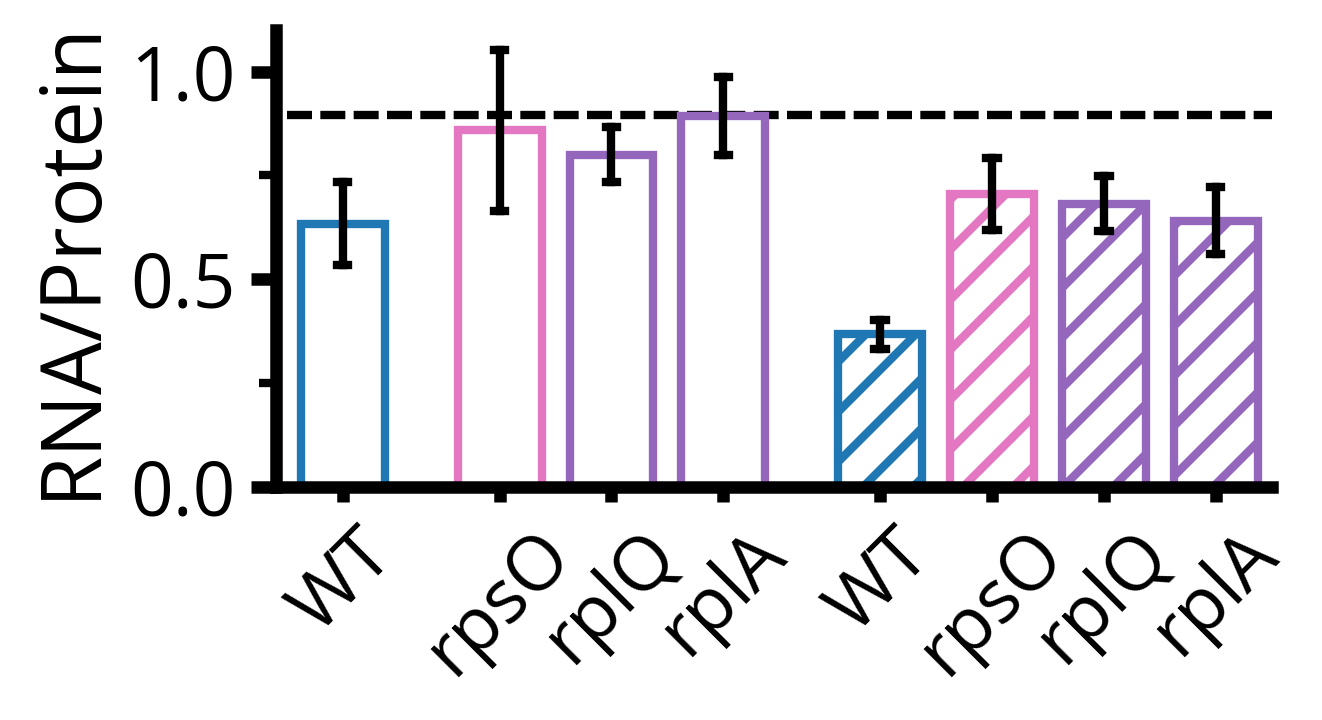

In [40]:
fig = plt.figure(figsize=(4.5,2.5))
bar_shift = 0.4
block_2_shift = 0.4
hatch_thickness = 2

mpl.rcParams['hatch.linewidth'] = hatch_thickness

ax = sns.barplot(data=RNA_prot_ratio_df_some_induction.loc[(strain_order,['0']),].reset_index(),x="Strain",y="RNA/Protein",errorbar=("se",2),
             order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")
ax = sns.barplot(data=RNA_prot_ratio_df_some_induction.loc[(strain_order,['25']),].reset_index(),x="Strain",y="RNA/Protein",errorbar=("se",2),
             order=strain_order,linewidth=2,width=0.75,errwidth=2,capsize=0.1,errcolor="black")
new_xticks = ax.get_xticks()+ax.get_xticks()
ax.set_xticks(new_xticks,labels=strain_order+strain_order)

# Apply custom colors to the bars and shift
color_list = [strain_pallette[strain] for strain in strain_order]
custom_colors = color_list + color_list

xticks_update = list(ax.get_xticks())
for i,zipped in enumerate(zip(ax.patches, custom_colors)):
    bar, color = zipped
    bar.set_color("white")
    bar.set_edgecolor(color)
    if i>0 and i<len(strain_order):
        x = bar.get_x()
        bar.set_x(x + bar_shift)
        xticks_update[i] = copy.copy(xticks_update[i]) + bar_shift
    elif i>=len(strain_order):
        x = bar.get_x()
        bar.set_x(x + bar_shift + len(strain_order) + block_2_shift)
        xticks_update[i] = xticks_update[i] + bar_shift + len(strain_order) + block_2_shift
        bar.set_hatch('//')
ax.set_xticks(xticks_update,labels=strain_order+strain_order)
# Shift the error bars
# ax.containers[1] usually contains the error bars if they are plotted
# This might need adjustment based on your specific plot
# error_bar_container = ax.containers[0]
for i,line in enumerate(ax.lines):
    if i>0 and i<len(strain_order):
        xdata = line.get_xdata()
        xdata_shifted = xdata + bar_shift
        line.set_xdata(xdata_shifted)
    elif i>=len(strain_order):
        xdata = line.get_xdata()
        xdata_shifted = xdata + bar_shift + len(strain_order) + block_2_shift
        line.set_xdata(xdata_shifted)

for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.xlabel("")

plt.tick_params(axis='x',rotation=45, labelsize=18, width=3)  # Set x-tick label size
plt.tick_params(axis='y', labelsize=18, width=3, length=6)  # Set x-tick label size
plt.tick_params(axis='y', direction='out', labelsize=18,  width=2, which='minor', length=4)
plt.ylabel(r"RNA/Protein",fontsize=20)

ax.set_yticks([0,0.5,1])
ax.set_yticks(ticks=[0.25,0.75],labels=["",""],minor=True)
lgd = plt.legend(fontsize=14) # You can set the fontsize for legend labels here
lgd.remove()
# lgd.set_title('Background', prop={'size': 14})
sns.despine(top=True,right=True)
plt.ylim(0,1.1)
plt.xlim(-0.6,2*len(strain_order) - 0.5 + bar_shift + block_2_shift)

plt.hlines(max_rna_prot_si,-0.5,2*len(strain_order) - 0.5 + bar_shift + block_2_shift,linestyles=(0, (3, 1)),color="black",linewidth=2,zorder=-100)

plt.tight_layout()
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/RNAProt_Plot_Fig.png",transparent=True,dpi=500,bbox_inches="tight")

## Figure 6B and E

### Load ppGpp Data

In [41]:
#samples to drop because of bad chromatography

names_to_drop = ["820_r6"]
# IS_threshold = 225000

ppGpp_data = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/ppGpp/ppGpp_Results_Set_2.xlsx",\
sheet_name="Formatted Data")
OD_data = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/ppGpp/OD_Measurements_Set_2.xlsx")
ppGpp_data = ppGpp_data.dropna(subset=["Strain"]).reset_index()
ppGpp_data = ppGpp_data[~ppGpp_data["Sample"].isin(names_to_drop)]
ppGpp_data["Replicate"] = ppGpp_data["Replicate"].astype(int)
ppGpp_data = ppGpp_data.reset_index().set_index(["Strain","Replicate"]).join(OD_data.set_index(["Strain","Replicate"]))
ppGpp_data = ppGpp_data.reset_index().set_index(["Strain"])

## IS threhold (experimental)
# ppGpp_data = ppGpp_data[(ppGpp_data["IS"]>IS_threshold)]

ppGpp_data["GDP (nM/OD)"] = (ppGpp_data["GDP (nM in 20ul)"]/(500*ppGpp_data["OD"]))
ppGpp_data["GTP (nM/OD)"] = (ppGpp_data["GTP (nM in 20ul)"]/(500*ppGpp_data["OD"]))
ppGpp_data["ppGpp (nM/OD)"] = (ppGpp_data["ppGpp (nM in 20ul)"]/(500*ppGpp_data["OD"]))
ppGpp_data["pppGpp (nM/OD)"] = (ppGpp_data["pppGpp (nM in 20ul)"]/(500*ppGpp_data["OD"]))

ppGpp_data["(p)ppGpp (nM in 20ul)"] = ppGpp_data["ppGpp (nM in 20ul)"]+ppGpp_data["pppGpp (nM in 20ul)"]
ppGpp_data["(p)ppGpp (nM/OD)"] = ppGpp_data["ppGpp (nM/OD)"]+ppGpp_data["pppGpp (nM/OD)"]

ppGpp_data["All Species (nM in 20ul)"] = ppGpp_data["ppGpp (nM in 20ul)"]+\
                                      ppGpp_data["pppGpp (nM in 20ul)"]+\
                                      ppGpp_data["GDP (nM in 20ul)"]+\
                                      ppGpp_data["GTP (nM in 20ul)"]
ppGpp_data["All Species (nM/OD)"] = ppGpp_data["ppGpp (nM/OD)"]+\
                                      ppGpp_data["pppGpp (nM/OD)"]+\
                                      ppGpp_data["GDP (nM/OD)"]+\
                                      ppGpp_data["GTP (nM/OD)"]

ppGpp_data["(p)ppGpp Fraction"] = ppGpp_data["(p)ppGpp (nM in 20ul)"]/ppGpp_data["All Species (nM in 20ul)"]

strain_name_map = {787:('WT','+'), 825:('WT','-'), 747:('tufA','+'), 824:('tufA','-'),
                   814:('rplL','+'), 818:('rplL','-'), 816:('infA','+'),820:('infA','-'),
                   817:('pheT','+'), 821:('pheT','-'), 815:('fusA','+'),819:('fusA','-'),
                   822:('fusA*','+'), 823:('fusA*','-'), 806:(r'$p_{AHL}$-fusA','+'),808:(r'$p_{AHL}$-fusA','-')}

# Define a custom palette, style consistent with rest of figure
strain_pallette = {'WT':(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), \
                   'tufA':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'rplL':(0.7901960784313726, 0.7019607843137254, 0.8705882352941177), \
                   'infA':(0.8874509803921569, 0.40705882352941175, 0.40980392156862744), \
                   'pheT':(1.0, 0.4980392156862745, 0.054901960784313725), \
                   'fusA':(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   r'$p_{AHL}$-fusA': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                   'fusA*':(0.5803921568627451, 0.403921568627451, 0.7411764705882353)}

ppGpp_data = ppGpp_data.reset_index()
ppGpp_data["Strain"] = ppGpp_data["Strain"].apply(lambda x: int(x[2:]))
ppGpp_data["Gene"] = ppGpp_data["Strain"].apply(lambda x: strain_name_map[x][0])
ppGpp_data["relA"] = ppGpp_data["Strain"].apply(lambda x: strain_name_map[x][1])
ppGpp_data = ppGpp_data.set_index(["Gene","relA"]).sort_index()
ppGpp_data["1/(p)ppGpp (OD/nM)"] = 1/ppGpp_data["(p)ppGpp (nM/OD)"]

/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():
/home/de64/micromamba/envs/crispri/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


### Load RNA/Prot Data

In [42]:
def get_sample_idx(sample_name_list):
    sample_idx = []
    for sample_name in sample_name_list:
        strain,replicate = sample_name.split("\n")
        replicate = int(replicate[1:])
        sample_idx.append((strain,replicate))
    return sample_idx

Protein_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_1.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_2.xlsx",skiprows=26,index_col=0,usecols=range(1,14))
Protein_data_1 = pd.concat([Protein_data_plate_1,Protein_data_plate_2]).reset_index(drop=True)

RNA_data_plate_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_1.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_plate_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_2.xlsx",skiprows=30,index_col=0,usecols=range(1,14))
RNA_data_1 = pd.concat([RNA_data_plate_1,RNA_data_plate_2]).reset_index(drop=True)

Protein_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skipfooter=11,index_col=0,usecols=range(2))['Concentrations (ug/mL)'].to_dict()
RNA_plate_map_standard_dict = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skipfooter=9,index_col=0,usecols=range(2))['Concentrations (ng/ul)'].to_dict()

Protein_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/Protein_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
Protein_plate_map_merged_1 = pd.concat([Protein_plate_map_1,Protein_plate_map_2]).reset_index(drop=True)
Protein_plate_map_merged_1.columns = Protein_plate_map_merged_1.columns.astype(int)

RNA_plate_map_1 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_1.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_2 = pd.read_excel("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Data/Translation_Knockdowns/RNA_Protein/RNA_Plate_Map_2.xlsx",skiprows=9,index_col=0,usecols=range(13))
RNA_plate_map_merged_1 = pd.concat([RNA_plate_map_1,RNA_plate_map_2]).reset_index(drop=True)
RNA_plate_map_merged_1.columns = RNA_plate_map_merged_1.columns.astype(int)

protein_samples_list_1,protein_sample_vals_list_1 = linear_regression(Protein_data_1,Protein_plate_map_merged_1,Protein_plate_map_standard_dict)
RNA_samples_list_1,RNA_sample_vals_list_1 = linear_regression(RNA_data_1,RNA_plate_map_merged_1,RNA_plate_map_standard_dict)

protein_samples_idx_1 = get_sample_idx(protein_samples_list_1)
Protein_output_df_1 = pd.DataFrame(protein_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))

RNA_output_df_1 = (pd.DataFrame(RNA_sample_vals_list_1,index=pd.MultiIndex.from_tuples(protein_samples_idx_1,names=["Strain","Replicate"]))/2)*20
RNA_prot_ratio_df_1 = (RNA_output_df_1/Protein_output_df_1).sort_index()

RNA_prot_ratio_df_1 = RNA_prot_ratio_df_1.reset_index().set_index(["Strain","Replicate"])

RNA_prot_ratio_df = pd.concat([RNA_prot_ratio_df_1]).sort_index()
RNA_prot_ratio_df_translation = RNA_prot_ratio_df.reset_index()
RNA_prot_ratio_df_translation["Strain"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: int(x[2:]))
strain_name_map = {787:('WT','+'), 825:('WT','-'), 747:('tufA','+'), 824:('tufA','-'),
                   814:('rplL','+'), 818:('rplL','-'), 816:('infA','+'),820:('infA','-'),
                   817:('pheT','+'), 821:('pheT','-'), 815:('fusA','+'),819:('fusA','-'),
                   822:('fusA*','+'), 823:('fusA*','-'), 806:(r'$p_{AHL}$-fusA','+'),808:(r'$p_{AHL}$-fusA','-')}

RNA_prot_ratio_df_translation["Strain Name"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][0])
RNA_prot_ratio_df_translation["relA"] = RNA_prot_ratio_df_translation["Strain"].apply(lambda x: strain_name_map[x][1])
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.drop(columns=["Strain"], axis=0)
RNA_prot_ratio_df_translation = RNA_prot_ratio_df_translation.set_index(["Strain Name","relA","Replicate"])
RNA_prot_ratio_df_translation.columns = ['RNA/Protein']

LOQ: 0.1676043733933667
LOQ: 0.3112222799012499


### Merge and Plot

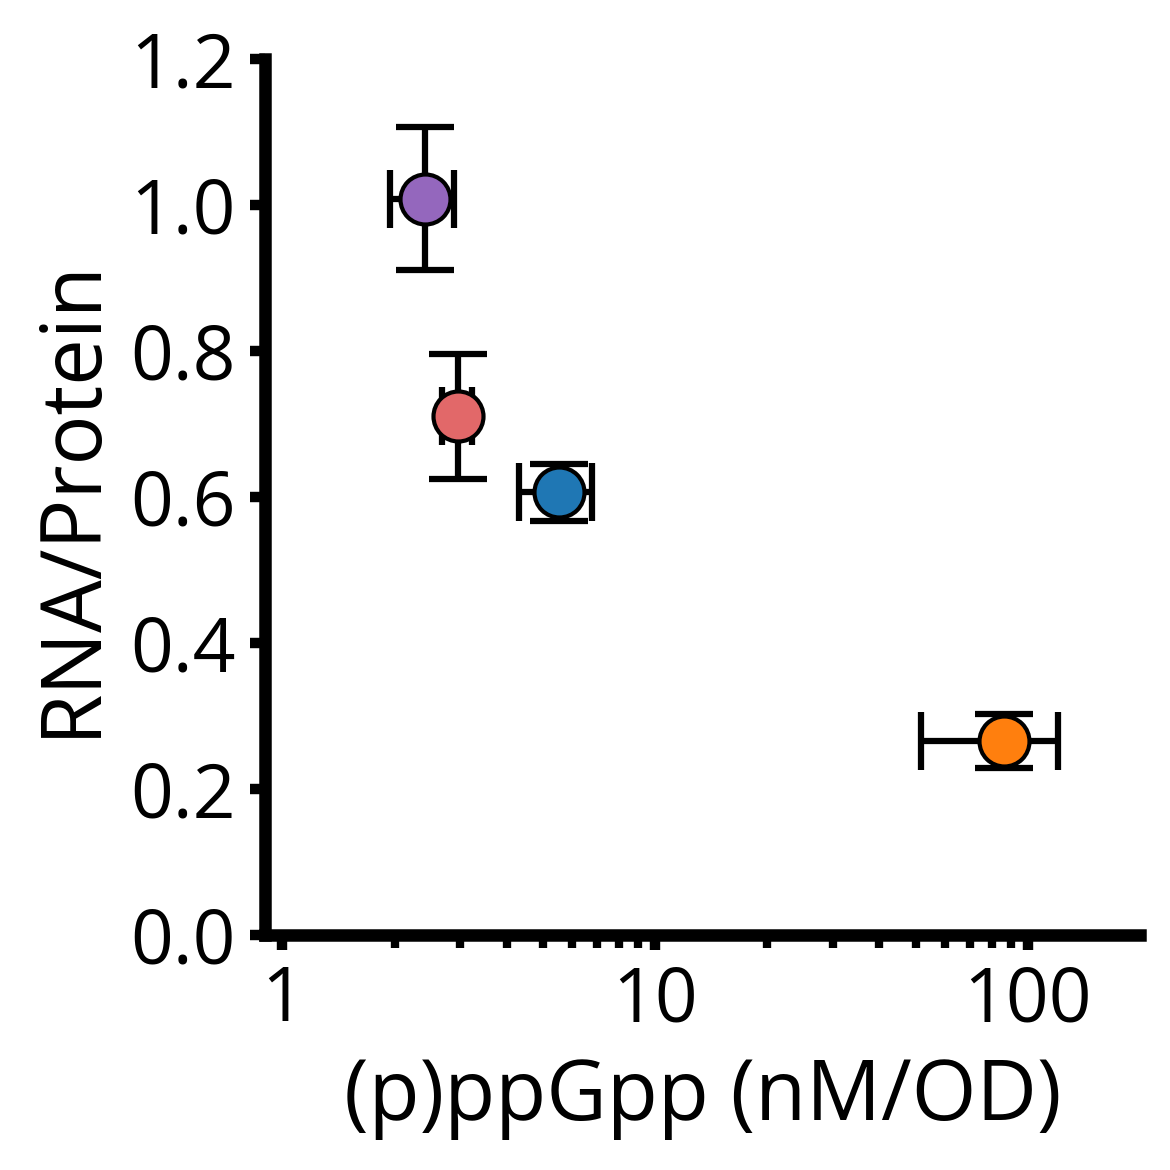

In [43]:
strain_order = ["WT","infA","pheT",r"$p_{AHL}$-fusA"]

ppGpp_data_subset = ppGpp_data.loc[strain_order]
RNA_prot_ratio_df_translation_subset = RNA_prot_ratio_df_translation.loc[strain_order]

mean_RNA_Prot_df = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","relA"]).mean()
mean_RNA_Prot_df.columns = ["Mean"]
mean_RNA_Prot_df["SEM"] = RNA_prot_ratio_df_translation_subset.groupby(["Strain Name","relA"]).sem()['RNA/Protein']

ppGpp_RNA_Prot_data = ppGpp_data_subset.reset_index().set_index(["Gene","relA","Replicate"]).join(RNA_prot_ratio_df_translation_subset.reset_index().rename(\
                                                        columns={"Strain Name":"Gene"}).set_index(["Gene","relA","Replicate"]),how="inner")
ppGpp_RNA_Prot_data_mean = ppGpp_RNA_Prot_data.groupby(["Gene","relA"])[["(p)ppGpp (nM/OD)","RNA/Protein"]].mean()
ppGpp_RNA_Prot_data_sem = ppGpp_RNA_Prot_data.groupby(["Gene","relA"])[["(p)ppGpp (nM/OD)","RNA/Protein"]].sem()
ppGpp_RNA_Prot_data_agg = ppGpp_RNA_Prot_data_mean.join(ppGpp_RNA_Prot_data_sem.rename(columns={"(p)ppGpp (nM/OD)":"(p)ppGpp (nM/OD) SEM","RNA/Protein":"RNA/Protein SEM"}))

fig = plt.figure(figsize=(4,4))
xlinspace = np.logspace(0,150,num=5000)
# plt.scatter(ppGpp_RNA_Prot_data_agg["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg["RNA/Protein"],s=50,linewidth=1,edgecolor="black")
# Apply custom colors to the bars and shift

color_list = [strain_pallette[strain] for strain in strain_order]

# Create a scatter plot with error bars
for i,gene_name in enumerate(strain_order):
    ppGpp_RNA_Prot_data_agg_wt_only = ppGpp_RNA_Prot_data_agg.reset_index()[ppGpp_RNA_Prot_data_agg.reset_index()["relA"]=="+"].set_index("Gene").loc[gene_name]
    ppGpp_RNA_Prot_data_agg_rela_only = ppGpp_RNA_Prot_data_agg.reset_index()[ppGpp_RNA_Prot_data_agg.reset_index()["relA"]=="-"].set_index("Gene").loc[gene_name]

    plt.errorbar(ppGpp_RNA_Prot_data_agg_wt_only["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg_wt_only["RNA/Protein"],\
                 xerr=2*ppGpp_RNA_Prot_data_agg_wt_only["(p)ppGpp (nM/OD) SEM"], yerr=2*ppGpp_RNA_Prot_data_agg_wt_only["RNA/Protein SEM"],\
                 fmt='o', ecolor='black', capsize=7, label="Data with error bars", markeredgecolor='black',\
             markerfacecolor=color_list[i],markersize=12,capthick=1.5,elinewidth=1.5)

plt.ylabel("RNA/Protein",fontsize=20)
plt.xlabel(r"(p)ppGpp (nM/OD)",fontsize=20)

plt.xscale("log")
plt.xlim(0.9,200)
plt.xticks([1,10,100],["1","10","100"])
plt.xticks([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90],minor=True)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])

plt.ylim(0,1.2)

plt.tick_params(axis='both', labelsize=18, width=2.5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=18, width=2, length=3, which="minor")  # Set x-tick label size
sns.despine(top=True,right=True)
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/ppGpp_RNA_Prot_Bivariate_WT.png",
                        dpi=500,transparent=True,bbox_inches="tight")

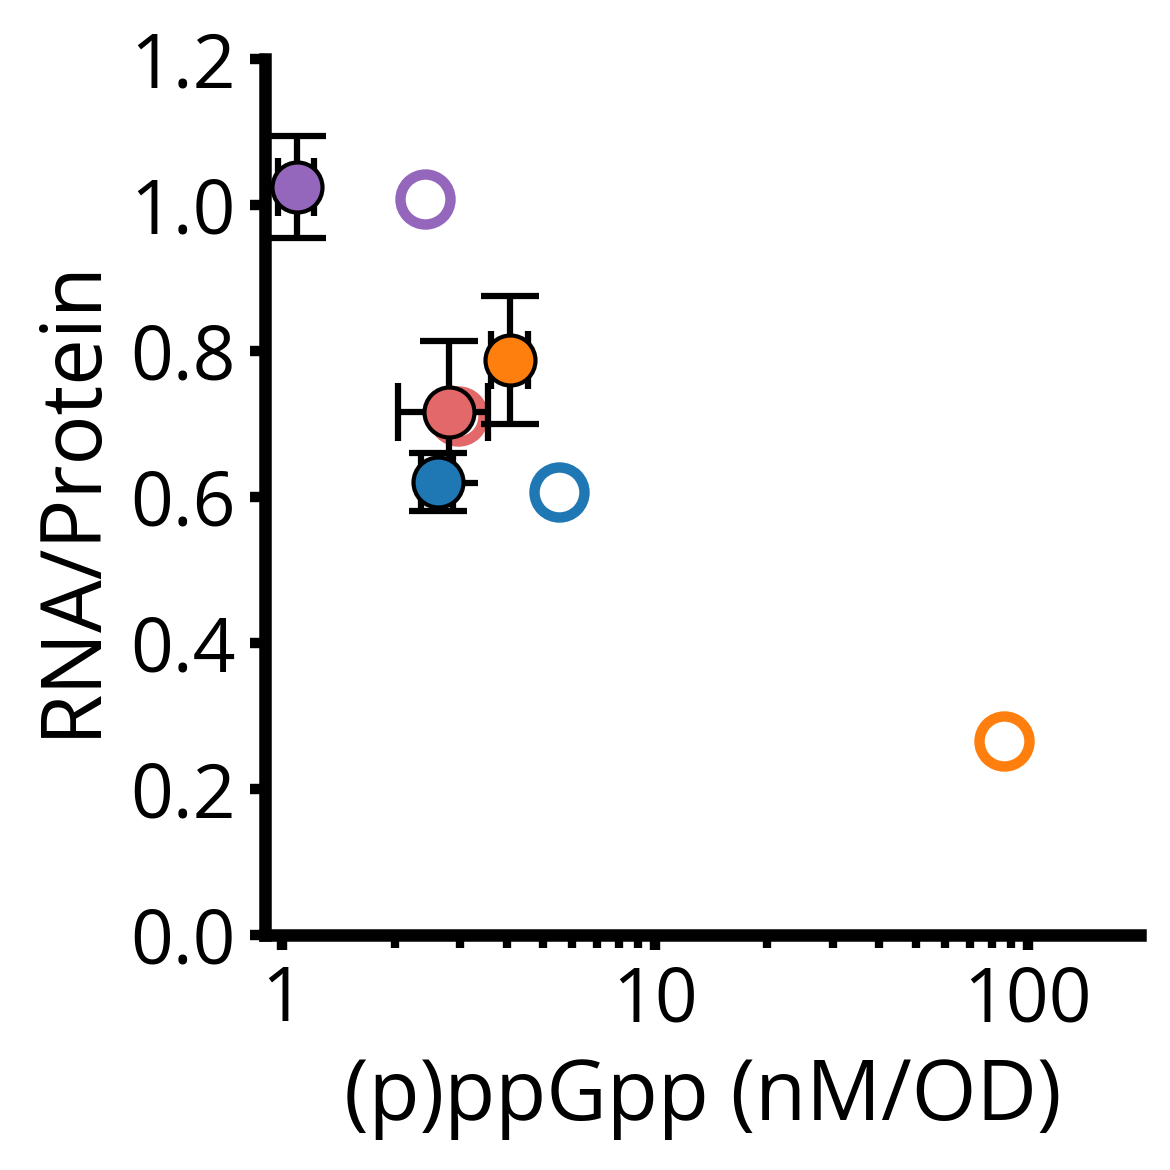

In [44]:
fig = plt.figure(figsize=(4,4))
xlinspace = np.logspace(0,150,num=5000)
# plt.scatter(ppGpp_RNA_Prot_data_agg["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg["RNA/Protein"],s=50,linewidth=1,edgecolor="black")
# Apply custom colors to the bars and shift
strain_order = ["WT","infA","pheT",r"$p_{AHL}$-fusA"]

color_list = [strain_pallette[strain] for strain in strain_order]

# Create a scatter plot with error bars
for i,gene_name in enumerate(strain_order):
    ppGpp_RNA_Prot_data_agg_wt_only = ppGpp_RNA_Prot_data_agg.reset_index()[ppGpp_RNA_Prot_data_agg.reset_index()["relA"]=="+"].set_index("Gene").loc[gene_name]
    ppGpp_RNA_Prot_data_agg_rela_only = ppGpp_RNA_Prot_data_agg.reset_index()[ppGpp_RNA_Prot_data_agg.reset_index()["relA"]=="-"].set_index("Gene").loc[gene_name]

    # plt.errorbar(ppGpp_RNA_Prot_data_agg_wt_only["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg_wt_only["RNA/Protein"],\
    #              fmt='o', ecolor='black', capsize=7, label="Data with error bars", markeredgecolor='black',\
    #          markerfacecolor=color_list[i],markersize=12,alpha=0.5)

    plt.errorbar(ppGpp_RNA_Prot_data_agg_wt_only["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg_wt_only["RNA/Protein"],\
             fmt='o', markeredgecolor=color_list[i],markerfacecolor="white",markersize=12, markeredgewidth=2.5,zorder=-9)

    plt.errorbar(ppGpp_RNA_Prot_data_agg_rela_only["(p)ppGpp (nM/OD)"],ppGpp_RNA_Prot_data_agg_rela_only["RNA/Protein"],\
                 xerr=2*ppGpp_RNA_Prot_data_agg_rela_only["(p)ppGpp (nM/OD) SEM"], yerr=2*ppGpp_RNA_Prot_data_agg_rela_only["RNA/Protein SEM"],\
                 fmt='o', ecolor='black', capsize=7, label="Data with error bars", markeredgecolor='black',\
             markerfacecolor=color_list[i],markersize=12,capthick=1.5,elinewidth=1.5,zorder=-8)


# plt.scatter(ppGpp_RNA_Prot_data_wu["g"]/scaling_alpha,ppGpp_RNA_Prot_data_wu["RNA/Protein"],color="grey",alpha=0.7,label="Wu et al. Data",s=25)
# plt.plot(xlinspace,y_n1, zorder=-15, linestyle="--", alpha=0.7, color="grey")
plt.tick_params(axis="both", labelsize=18)
plt.ylabel("RNA/Protein",fontsize=20)
plt.xlabel(r"(p)ppGpp (nM/OD)",fontsize=20)

plt.xscale("log")
plt.xlim(0.9,200)
plt.xticks([1,10,100],["1","10","100"])
plt.xticks([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90],minor=True)
plt.yticks([0,0.2,0.4,0.6,0.8,1.0,1.2])

# plt.xlim(0,300)
# plt.xscale("symlog", linthresh=10, linscale=2)
# plt.xticks([0,5,10,100],["0","5","10","100"])
# plt.xticks([1,2,3,4,6,7,8,9,20,30,40,50,60,70,80,90],minor=True)
# plt.legend(fontsize=12)
plt.ylim(0,1.2)

plt.tick_params(axis='both', labelsize=18, width=2.5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=18, width=2, length=3, which="minor")  # Set x-tick label size
sns.despine(top=True,right=True)
for spine in plt.gca().spines.values():
    spine.set_linewidth(3)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/ppGpp_RNA_Prot_Bivariate_relA.png",
            dpi=500,transparent=True,bbox_inches="tight")

## Figure 6C

In [45]:
R_max = 0.793 ## max ribosome levels
gr_ref = 2 ## reference growth rate
R_ref = 0.3 ## reference ribosome levels
R_0 = 0.03 ## based on dai data
k = 0.334 ## based on wu repressor function
e_max = 20 ##max elongatoin rate

def g_vs_gr_elong(gr,R_max=R_max,gr_ref=gr_ref,R_ref=R_ref,R_0=R_0,k=k,):
    ##setting constant based on argument (sketch)
    c_tau_d = ((R_max-R_ref)*k)/gr_ref
    alpha = c_tau_d/(R_max-R_0)
    phi = alpha*gr    
    g =  (phi/(1-phi/k))
    return g

g_ref = g_vs_gr_elong(gr_ref)

def g_vs_gr_charge(gr,g_ref=g_ref,gr_ref=gr_ref,e_max=e_max,R_0=R_0):
    g0 = g_ref*(1+(gr_ref/(e_max*R_0)))
    ##setting constant based on argument (sketch)
    g = g0/(1+gr/(e_max*R_0))

    return g

## from https://stackoverflow.com/questions/34017866/arrow-on-a-line-plot

def add_arrow(line, position=None, direction='right', size=15, color=None, zorder=0):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size,
        zorder=zorder
    )

#### Growth vs ppGpp

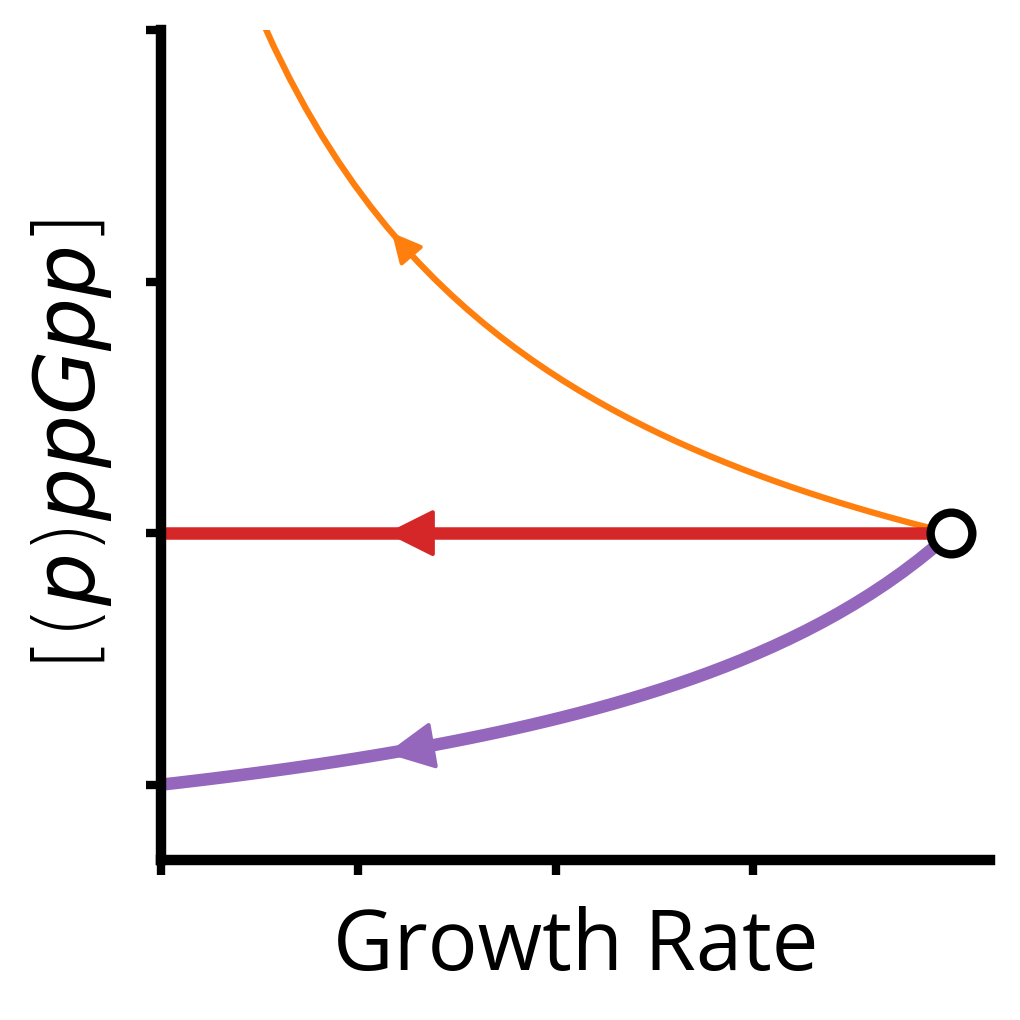

In [46]:
label_idx = 25
null_label_idx = 15

fig = plt.figure(figsize=(3.5,3.5))
ax = plt.subplot(1,1,1)

lamb = np.linspace(0,gr_ref,num=50)
nutrient_line = g_vs_gr_charge(lamb)/g_ref
efg_line = g_vs_gr_elong(lamb)/g_ref
null_line = np.repeat(g_ref,len(lamb))/g_ref

line = plt.plot(lamb,efg_line,color=(0.5803921568627451, 0.403921568627451, 0.7411764705882353),linewidth=3,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
line = plt.plot(lamb,nutrient_line,color=(1.0, 0.4980392156862745, 0.054901960784313725),linewidth=1.5,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=15,zorder=-10)
line = plt.plot(lamb,null_line,color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),linewidth=3,zorder=-9)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
sns.scatterplot(x=[gr_ref],y=[g_ref/g_ref],zorder=10,s=100,color="white",linewidth=2,edgecolor="black")

plt.tick_params(axis="both", labelsize=16, width=2)
plt.xticks([0.,0.5,1.0,1.5],["","","",""])
plt.yticks([0,1,2,3,4],["","","","",""])
plt.ylabel(r"$[(p)ppGpp]$",fontsize=20)
plt.xlabel("Growth Rate",fontsize=20)
plt.xlim(0,2.1)
plt.ylim(-0.3,3)

ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine

dlamb = lamb[label_idx+1] - lamb[label_idx]
defg_line = efg_line[label_idx+1] - efg_line[label_idx]
dnutrient_line = nutrient_line[label_idx+1] - nutrient_line[label_idx]

rotn_efg_line = np.degrees(np.arctan2(defg_line, dlamb))
rotn_nutrient_line = np.degrees(np.arctan2(dnutrient_line, dlamb))

dnull_line = null_line[null_label_idx+1] - null_line[null_label_idx]
rotn_null_line = np.degrees(np.arctan2(dnull_line, dlamb))
sns.despine()

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/ppGpp_model_schematic_Main.png",dpi=300,\
            transparent=True,bbox_inches="tight")

#### Growth vs R-protein

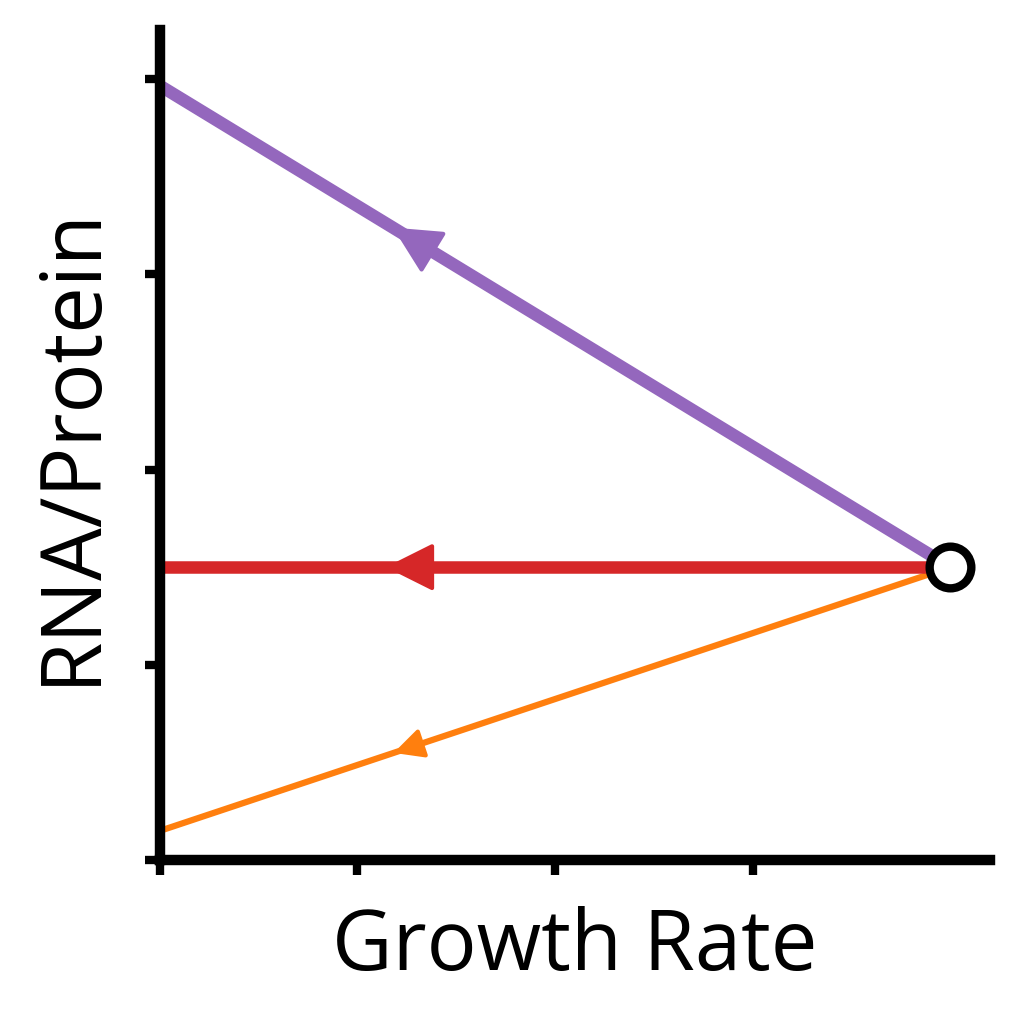

In [47]:
lamb = np.linspace(0,gr_ref)
nutrient_slope = (R_ref-R_0)/gr_ref
efg_slope = (R_ref-R_max)/gr_ref

nutrient_line = R_0 + lamb*nutrient_slope
efg_line = R_max + lamb*efg_slope
null_line = np.repeat(R_ref,len(lamb))

label_idx = 25
fig = plt.figure(figsize=(3.5,3.5))
ax = plt.subplot(1,1,1)

line = plt.plot(lamb,efg_line,color=(0.5803921568627451, 0.403921568627451, 0.7411764705882353),linewidth=3,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
line = plt.plot(lamb,nutrient_line,color=(1.0, 0.4980392156862745, 0.054901960784313725),linewidth=1.5,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=15,zorder=-10)
line = plt.plot(lamb,null_line,color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),linewidth=3,zorder=-9)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
sns.scatterplot(x=[gr_ref],y=[R_ref],zorder=10,s=100,color="white",linewidth=2,edgecolor="black")

plt.tick_params(axis="both", labelsize=16, width=2)
plt.xticks([0.,0.5,1.0,1.5],["","","",""])
plt.yticks([0,0.2,0.4,0.6,0.8],["","","","",""])
plt.ylabel("RNA/Protein",fontsize=20)
plt.xlabel("Growth Rate",fontsize=20)

ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine

dlamb = lamb[label_idx+1] - lamb[label_idx]
defg_line = efg_line[label_idx+1] - efg_line[label_idx]
dnutrient_line = nutrient_line[label_idx+1] - nutrient_line[label_idx]
dnull_line = null_line[label_idx+1] - null_line[label_idx]

rotn_efg_line = np.degrees(np.arctan2(defg_line, dlamb))
rotn_nutrient_line = np.degrees(np.arctan2(dnutrient_line, dlamb))
rotn_null_line = np.degrees(np.arctan2(dnull_line, dlamb))

sns.despine()

plt.xlim(0,2.1)
plt.ylim(0,0.85)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/growth_model_schematic_Main.png",dpi=300,\
            transparent=True,bbox_inches="tight")

#### Growth vs Division
- Qualitative division size scaling
- Assume a repressor function of the same form as the ribosome function, but with arbitrary parameters

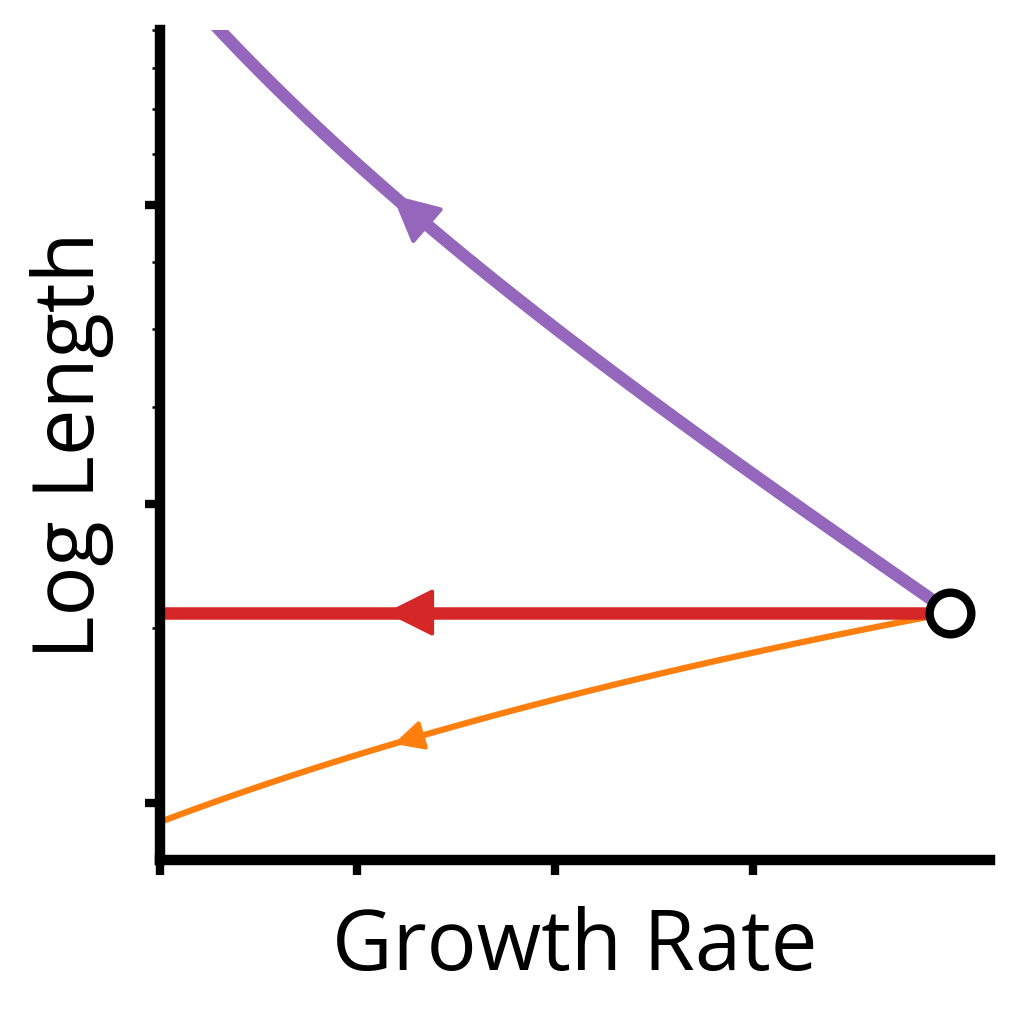

In [48]:
D_max = 14
D_0 = 1.5
div_k = 0.09

def division_hill_fn_n1(g, div_k=div_k, n=1, D_0=D_0, D_max=D_max):
    return ((div_k/((g**n)+div_k))*(D_max-D_0)) + D_0

fig = plt.figure(figsize=(3.5,3.5))
ax = plt.subplot(1,1,1)

lamb = np.linspace(0,gr_ref,num=50)
nutrient_line = g_vs_gr_charge(lamb)
efg_line = g_vs_gr_elong(lamb)
null_line = np.repeat(g_ref,len(lamb))
D_ref = division_hill_fn_n1(g_ref)

nutrient_line_div = division_hill_fn_n1(nutrient_line)
efg_line_div = division_hill_fn_n1(efg_line)
null_line_div = division_hill_fn_n1(null_line)

line = plt.plot(lamb,efg_line_div,color=(0.5803921568627451, 0.403921568627451, 0.7411764705882353),linewidth=3,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
line = plt.plot(lamb,nutrient_line_div,color=(1.0, 0.4980392156862745, 0.054901960784313725),linewidth=1.5,zorder=-10)[0]
add_arrow(line,position=0.6,direction='left',size=15,zorder=-10)
line = plt.plot(lamb,null_line_div,color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392),linewidth=3,zorder=-9)[0]
add_arrow(line,position=0.6,direction='left',size=25,zorder=-10)
sns.scatterplot(x=[gr_ref],y=[D_ref],zorder=10,s=100,color="white",linewidth=2,edgecolor="black")

# plt.tick_params(axis="both", labelsize=16, width=4,length=10)
# plt.tick_params(axis="y",which="minor",labelsize=12, width=3, length=5)
plt.tick_params(axis="both", labelsize=16, width=2)
plt.yscale("log",base=2)
plt.xticks([0.,0.5,1.0,1.5],["","","",""])
plt.yticks([2,4,8],["","",""])
plt.yticks([3,5,6,7,9,10,11,12],["","","","","","","",""],minor=True,)
plt.ylim(1.75,12)
plt.ylabel("Log Length",fontsize=20)
plt.xlabel("Growth Rate",fontsize=20)

ax.spines['bottom'].set_linewidth(2.5) # Set thickness of the bottom spine
ax.spines['left'].set_linewidth(2.5)   # Set thickness of the left spine
sns.despine()
plt.xlim(0,2.1)

plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/size_model_schematic_Main.png",dpi=300,\
            transparent=True,bbox_inches="tight")

## Figure 6D

In [49]:
# Get ontologies
obo_fname = download_go_basic_obo()

# Get ecoli association file (ecocyc)
gaf_handle = goatools.base.http_get("http://release.geneontology.org/2024-11-03/annotations/ecocyc.gaf.gz",fout="./ecocyc.gaf.gz")
gaf_fname = goatools.base.gunzip("./ecocyc.gaf.gz")

## Getting ontologies and other nonesense

obodag = GODag(obo_fname)
objanno = GafReader(gaf_fname)
ns2assoc = objanno.get_ns2assc()

gene_to_id = {assoc.DB_Symbol:assoc.DB_ID for assoc in objanno.associations}
inv_gene_to_id = {assoc.DB_ID:assoc.DB_Symbol for assoc in objanno.associations}
synonym_dict = {synonym:assoc.DB_ID for assoc in objanno.associations for synonym in assoc.DB_Synonym}
gene_to_id.update(synonym_dict)

  EXISTS: go-basic.obo
requests.get(http://release.geneontology.org/2024-11-03/annotations/ecocyc.gaf.gz, stream=True)
  WROTE: ./ecocyc.gaf.gz

go-basic.obo: fmt(1.2) rel(2024-10-27) 44,017 Terms
HMS:0:00:01.893985  58,540 annotations READ: ./ecocyc.gaf 


In [50]:
final_columns = ["Gene","Category"]
control_categories = ['OnlyPlasmid', 'NoTarget']
params_of_interest = ['Length','Instantaneous Growth Rate: Volume']
prolif_params = []
param_names = [r"Length ($ \mu m $)",r"Volume ($ \mu m^{3} $)"]
param_ranges = [(0.,10.),(0.,2.2)]
param_ticks = [[0,2,4,6,8,10],[0.,1.,2.]]

min_n_observations = 8
## minimum set from https://stats.stackexchange.com/questions/33300/determining-sample-size-necessary-for-bootstrap-method-proposed-method
mean_frac_sem_thr = 0.2

ss_estimator_df_dict = {"WT":WT_ss_estimators_df,"RelA":RelA_ss_estimators_df,"SpoT":SpoT_ss_estimators_df}
ss_estimator_df_control_dict = {}

for ss_estimator_key in ss_estimator_df_dict.keys():
    ss_estimators_df = ss_estimator_df_dict[ss_estimator_key]

    final_column_df = ss_estimators_df.reset_index().groupby("oDEPool7_id").first()[final_columns]
    ss_estimators_df["SEM/Location"] = (np.sqrt(ss_estimators_df["Estimator Variance"])/ss_estimators_df["Value"]).copy()
    ss_estimators_df = ss_estimators_df[ss_estimators_df["SEM/Location"]<mean_frac_sem_thr]
    ss_estimators_df = ss_estimators_df.reset_index().set_index(["oDEPool7_id"])
    
    ##hack to get both observatoins and proliferating observations (was broken)
    observation_df = ss_estimators_df[ss_estimators_df["Variable(s)"] == "Length"][["N Observations"]]
    observation_df = observation_df.join(ss_estimators_df[ss_estimators_df["Variable(s)"] == "Delta time (s)"][["N Observations Proliferating"]])
    
    variance_estimators_df = ss_estimators_df[["Variable(s)","Estimator Variance"]]
    ss_estimators_df = ss_estimators_df[["Variable(s)","Value"]]
    ss_estimators_df = ss_estimators_df.pivot(columns=["Variable(s)"])
    variance_estimators_df = variance_estimators_df.pivot(columns=["Variable(s)"])
    
    ss_estimators_df.columns = ss_estimators_df.columns.droplevel(0)
    variance_estimators_df.columns = variance_estimators_df.columns.droplevel(0)
    variance_estimators_df.columns = [column + " SEM" for column in variance_estimators_df.columns]
    variance_estimators_df = np.sqrt(variance_estimators_df)
    ss_estimators_df = ss_estimators_df.join(observation_df,on=['oDEPool7_id'])
    ss_estimators_df = ss_estimators_df.join(variance_estimators_df,on=['oDEPool7_id'])
    
    ss_estimators_df = ss_estimators_df[ss_estimators_df["N Observations"]>=min_n_observations]
    ss_estimators_df["Instantaneous Growth Rate: Volume"] = ss_estimators_df["Instantaneous Growth Rate: Volume"]/np.log(2)
    ss_estimators_df["Instantaneous Growth Rate: Volume SEM"] = ss_estimators_df["Instantaneous Growth Rate: Volume SEM"]/np.log(2)
    ss_estimators_df = ss_estimators_df.join(final_column_df)
    ss_estimators_df = ss_estimators_df.dropna(subset=params_of_interest)
    
    # ##removing controls
    ss_estimators_df_controls_only = ss_estimators_df[ss_estimators_df["Category"].isin(control_categories)]
    ss_estimators_df = ss_estimators_df[~ss_estimators_df["Category"].isin(control_categories)]
    
    ss_estimator_df_dict[ss_estimator_key] = ss_estimators_df
    ss_estimator_df_control_dict[ss_estimator_key] = ss_estimators_df_controls_only

WT_comparison_df = ss_estimator_df_dict["WT"][["Gene","Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Instantaneous Growth Rate: Volume":"Growth Rate","Instantaneous Growth Rate: Volume SEM":"Growth Rate SEM"})
RelA_comparison_df = ss_estimator_df_dict["RelA"][["Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Length":"RelA Length","Instantaneous Growth Rate: Volume":"RelA Growth Rate","Length SEM":"RelA Length SEM",\
                                        "Instantaneous Growth Rate: Volume SEM":"RelA Growth Rate SEM"})
SpoT_comparison_df = ss_estimator_df_dict["SpoT"][["Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Length":"SpoT Length","Instantaneous Growth Rate: Volume":"SpoT Growth Rate","Length SEM":"SpoT Length SEM",\
                                        "Instantaneous Growth Rate: Volume SEM":"SpoT Growth Rate SEM"})
ss_comparison_df = pd.concat([WT_comparison_df,RelA_comparison_df,SpoT_comparison_df],axis=1)
##check this later
# ss_comparison_df = ss_comparison_df.dropna(subset=["Length","Growth Rate","RelA Length","RelA Growth Rate","SpoT Length","SpoT Growth Rate"])
ss_comparison_df["Length Difference (RelA)"] = ss_comparison_df["RelA Length"] - ss_comparison_df["Length"]
ss_comparison_df["Length Difference (SpoT)"] = ss_comparison_df["SpoT Length"] - ss_comparison_df["Length"]


WT_control_comparison_df = ss_estimator_df_control_dict["WT"][["Gene","Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Instantaneous Growth Rate: Volume":"Growth Rate","Instantaneous Growth Rate: Volume SEM":"Growth Rate SEM"})
RelA_control_comparison_df = ss_estimator_df_control_dict["RelA"][["Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Length":"RelA Length","Instantaneous Growth Rate: Volume":"RelA Growth Rate","Length SEM":"RelA Length SEM",\
                                        "Instantaneous Growth Rate: Volume SEM":"RelA Growth Rate SEM"})
SpoT_control_comparison_df = ss_estimator_df_control_dict["SpoT"][["Instantaneous Growth Rate: Volume","Length","Instantaneous Growth Rate: Volume SEM","Length SEM"]].\
                        rename(columns={"Length":"SpoT Length","Instantaneous Growth Rate: Volume":"SpoT Growth Rate","Length SEM":"SpoT Length SEM",\
                                        "Instantaneous Growth Rate: Volume SEM":"SpoT Growth Rate SEM"})
ss_control_comparison_df = pd.concat([WT_control_comparison_df,RelA_control_comparison_df,SpoT_control_comparison_df],axis=1)
ss_control_comparison_df["Length Difference (RelA)"] = ss_control_comparison_df["RelA Length"] - ss_control_comparison_df["Length"]
ss_control_comparison_df["Length Difference (SpoT)"] = ss_control_comparison_df["SpoT Length"] - ss_control_comparison_df["Length"]
ss_control_comparison_df["Gene"]="EV"

In [53]:
glycolysis_genes

['aceF',
 'eno',
 'fbaA',
 'fbaB',
 'gapA',
 'glk',
 'gpmA',
 'gpmB',
 'gpmI',
 'mdh',
 'pfkA',
 'pfkB',
 'pgi',
 'pgk',
 'pykA',
 'pykF',
 'tpiA']

In [58]:
ribo = ['rplA', 'rplB', 'rplC', 'rplD', 'rplE', 'rplF', 'rplI',\
 'rplJ', 'rplK', 'rplL', 'rplM', 'rplN', 'rplO', 'rplP', \
 'rplQ', 'rplR', 'rplS', 'rplT', 'rplU', 'rplV', 'rplW', \
 'rplX', 'rplY', 'rpmA', 'rpmB', 'rpmC', 'rpmD', 'rpmE', \
 'rpmF', 'rpmG', 'rpmH', 'rpmI', 'rpmJ', 'rpsA', 'rpsB', \
 'rpsC', 'rpsD', 'rpsE', 'rpsF', 'rpsG', 'rpsH', 'rpsI', \
 'rpsJ', 'rpsK', 'rpsL', 'rpsM', 'rpsN', 'rpsO', 'rpsP', \
 'rpsQ', 'rpsR', 'rpsS', 'rpsT', 'rpsU', 'ykgM', 'ykgO']

trna_synthetases = ['alaS', 'argS', 'asnS', 'aspS', 'cysS', \
'glnS', 'gltX', 'glyQ', 'glyS', 'hisS', 'ileS', 'leuS', \
'lysS', 'lysU', 'metG', 'pheS', 'pheT', 'proS', 'serS', \
'thrS', 'trpS',  'tyrS', 'valS']

initation_factors = ["infA","infB"]

glycolysis_genes = ['aceF', 'eno', 'fbaA', 'fbaB', 'gapA',\
'glk', 'gpmA', 'gpmB', 'gpmI', 'mdh', 'pfkA', 'pfkB',\
'pgi', 'pgk', 'pykA', 'pykF', 'tpiA']

all_ribo = ribo + trna_synthetases + glycolysis_genes + initation_factors

ribo_relabel = {**{item: "Ribosome" for item in ribo},\
 **{item: "tRNA Synthetase" for item in trna_synthetases},\
 **{item: "Initiation" for item in initation_factors},\
 **{item: "Glycolysis" for item in glycolysis_genes}}

ss_comparison_ribo_df = ss_comparison_df[ss_comparison_df["Gene"].isin(all_ribo)].copy()
ss_comparison_ribo_df["Gene"] = ss_comparison_ribo_df["Gene"].astype(str)
ss_comparison_ribo_df["Ribo Type"] = ss_comparison_ribo_df["Gene"].apply(lambda x: ribo_relabel[x])

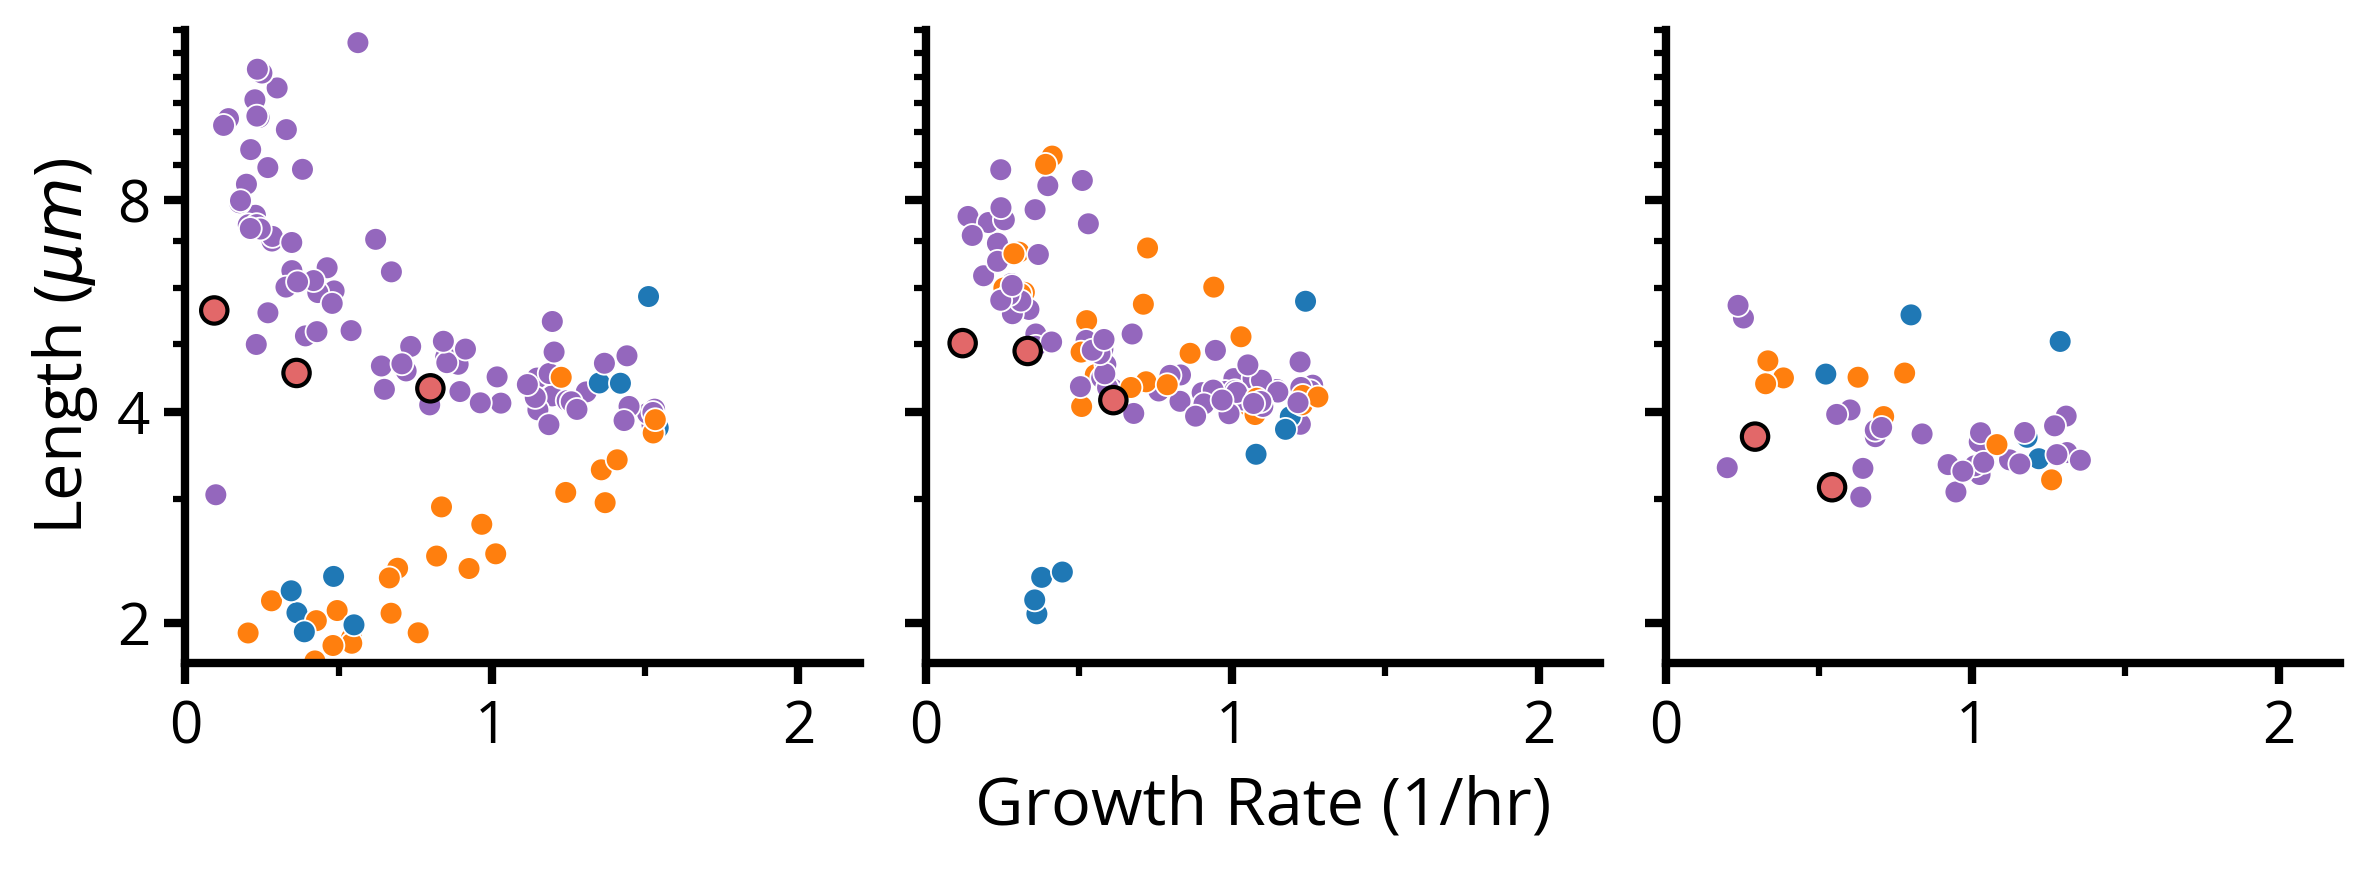

In [74]:
ss_comparison_ribo_df_block_1 = ss_comparison_ribo_df[~(ss_comparison_ribo_df["Ribo Type"] == "Initiation")]
ss_comparison_ribo_df_block_2 = ss_comparison_ribo_df[(ss_comparison_ribo_df["Ribo Type"] == "Initiation")]

sns.set_style()

fig = plt.figure(figsize=(8,3))
plt.subplot(1,3,1)

plt.xlim(0,2.2)
plt.ylim(1.75,14)
plt.yscale("log", base=2)
plt.xticks(ticks=[0,1,2],labels=["0","1","2"])
plt.xticks(ticks=[0.5,1.5],labels=["",""],minor=True)
plt.yticks(ticks=[2,4,8],labels=["2","4","8"])
plt.yticks(ticks=[3,5,6,7,9,10,11,12,13,14],labels=["","","","","","","","","",""],minor=True)
plt.tick_params(axis='both', labelsize=14, width=2, length=5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=14, width=1.5, length=3, which="minor")  # Set x-tick label size

plt.yticks(ticks=[2,4,8],labels=["2","4","8"])

sns.scatterplot(x=ss_comparison_ribo_df_block_1["Growth Rate"],\
            y=ss_comparison_ribo_df_block_1["Length"],s=30,\
            hue=ss_comparison_ribo_df_block_1["Ribo Type"],\
            palette=[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                     (1.0, 0.4980392156862745, 0.054901960784313725),\
                    (0.12, 0.47, 0.71)],zorder=-12)

sns.scatterplot(x=ss_comparison_ribo_df_block_2["Growth Rate"],\
            y=ss_comparison_ribo_df_block_2["Length"],s=40,\
            hue=ss_comparison_ribo_df_block_2["Ribo Type"],\
            palette=[(0.8874509803921569, 0.40705882352941175, 0.40980392156862744)],zorder=-11,\
               linewidth=1,edgecolor="black")

plt.ylabel(r"Length ($\mu m$)",fontsize=16)
plt.xlabel(r"",fontsize=16)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

legend = plt.legend(fontsize=16)
legend.remove()
sns.despine(right=True,top=True)

plt.subplot(1,3,2)

plt.xlim(0,2.2)
plt.ylim(1.75,14)
plt.yscale("log", base=2)
plt.xticks(ticks=[0,1,2],labels=["0","1","2"])
plt.xticks(ticks=[0.5,1.5],labels=["",""],minor=True)
plt.yticks(ticks=[2,4,8],labels=["","",""])
plt.yticks(ticks=[3,5,6,7,9,10,11,12,13,14],labels=["","","","","","","","","",""],minor=True)
plt.tick_params(axis='both', labelsize=14, width=2, length=5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=14, width=1.5, length=3, which="minor")  # Set x-tick label size

sns.scatterplot(x=ss_comparison_ribo_df_block_1["RelA Growth Rate"],\
            y=ss_comparison_ribo_df_block_1["RelA Length"],s=30,\
            hue=ss_comparison_ribo_df_block_1["Ribo Type"],\
            palette=[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                     (1.0, 0.4980392156862745, 0.054901960784313725),\
                    (0.12, 0.47, 0.71)],zorder=-12)

sns.scatterplot(x=ss_comparison_ribo_df_block_2["RelA Growth Rate"],\
            y=ss_comparison_ribo_df_block_2["RelA Length"],s=40,\
            hue=ss_comparison_ribo_df_block_2["Ribo Type"],\
            palette=[(0.8874509803921569, 0.40705882352941175, 0.40980392156862744)],
                zorder=-11,linewidth=1, edgecolor="black")

plt.ylabel(r"",fontsize=16)
plt.xlabel(r"Growth Rate (1/hr)",fontsize=16)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

legend = plt.legend(fontsize=16)
legend.remove()
sns.despine(right=True,top=True)

plt.subplot(1,3,3)

plt.xlim(0,2.2)
plt.ylim(1.75,14)
plt.yscale("log", base=2)
plt.xticks(ticks=[0,1,2],labels=["0","1","2"])
plt.xticks(ticks=[0.5,1.5],labels=["",""],minor=True)
plt.yticks(ticks=[2,4,8],labels=["","",""])
plt.yticks(ticks=[3,5,6,7,9,10,11,12,13,14],labels=["","","","","","","","","",""],minor=True)
plt.tick_params(axis='both', labelsize=14, width=2, length=5)  # Set x-tick label size
plt.tick_params(axis='both', labelsize=14, width=1.5, length=3, which="minor")  # Set x-tick label size

sns.scatterplot(x=ss_comparison_ribo_df_block_1["SpoT Growth Rate"],\
            y=ss_comparison_ribo_df_block_1["SpoT Length"],s=30,\
            hue=ss_comparison_ribo_df_block_1["Ribo Type"],\
            palette=[(0.5803921568627451, 0.403921568627451, 0.7411764705882353),\
                     (1.0, 0.4980392156862745, 0.054901960784313725),\
                    (0.12, 0.47, 0.71),],zorder=-12)

sns.scatterplot(x=ss_comparison_ribo_df_block_2["SpoT Growth Rate"],\
            y=ss_comparison_ribo_df_block_2["SpoT Length"],s=40,\
            hue=ss_comparison_ribo_df_block_2["Ribo Type"],\
            palette=[(0.8874509803921569, 0.40705882352941175, 0.40980392156862744)],\
                zorder=-11,linewidth=1, edgecolor="black")

plt.ylabel(r"",fontsize=16)
plt.xlabel(r"",fontsize=16)

for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

plt.subplots_adjust(wspace=0.4)

legend = plt.legend(fontsize=16)
legend.remove()
# plt.tight_layout()
sns.despine(right=True,top=True)
plt.savefig("/home/de64/group/de64/CRISPRi_Libraries/dev_notebooks/2024-11-23_Figure_Notebooks/Figure_6/Length_Growth_Ribo_NoStalk.png",
            bbox_inches="tight",dpi=500,transparent=True)